In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

In [2]:
def f(x):
    return 2*x**2 - 4*x + 5

# Numerical derivatives

In [4]:
def forward_derivative(f, x, h):
    return (f(x+h) - f(x))/h

In [5]:
def backward_derivative(f, x, h):
    return (f(x) - f(x-h))/h

In [6]:
def central_derivative(f, x, h):
    return (f(x+h) - f(x-h))/(2*h)

In [7]:
xs = np.arange(-5, 5, 0.25)

In [8]:
ys = f(xs)

In [9]:
fd = forward_derivative(f, xs, h=0.01)

In [10]:
((f(xs) - f(xs-0.01))/0.01)[0]

np.float64(-24.01999999999873)

In [11]:
(f(xs+0.01) - f(xs))/0.01

array([-2.398e+01, -2.298e+01, -2.198e+01, -2.098e+01, -1.998e+01,
       -1.898e+01, -1.798e+01, -1.698e+01, -1.598e+01, -1.498e+01,
       -1.398e+01, -1.298e+01, -1.198e+01, -1.098e+01, -9.980e+00,
       -8.980e+00, -7.980e+00, -6.980e+00, -5.980e+00, -4.980e+00,
       -3.980e+00, -2.980e+00, -1.980e+00, -9.800e-01,  2.000e-02,
        1.020e+00,  2.020e+00,  3.020e+00,  4.020e+00,  5.020e+00,
        6.020e+00,  7.020e+00,  8.020e+00,  9.020e+00,  1.002e+01,
        1.102e+01,  1.202e+01,  1.302e+01,  1.402e+01,  1.502e+01])

In [12]:
(f(xs+0.01) - f(xs-0.01))/0.02

array([-24., -23., -22., -21., -20., -19., -18., -17., -16., -15., -14.,
       -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,
        -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
         9.,  10.,  11.,  12.,  13.,  14.,  15.])

In [13]:
bd = backward_derivative(f, xs, h=0.01)

In [14]:
cd = central_derivative(f, xs, h=0.01)

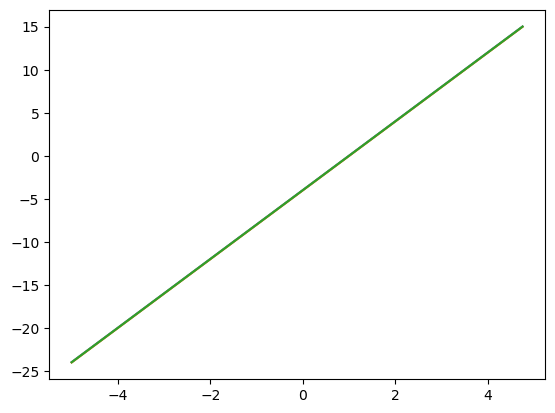

In [15]:
plt.plot(xs, fd)
plt.plot(xs, bd)
plt.plot(xs, cd)
plt.show()

# Partial derivatives

In [16]:
def f(a, b, c):
    return a*b + c

In [17]:
h = 1e-3

In [18]:
# fix input
a = 2
b = -4
c = 6

In [19]:
f(a, b, c)

-2

In [20]:
f(a+h, b, c)

-2.0039999999999996

In [21]:
(f(a+h, b, c) - f(a, b, c))/h

-3.9999999999995595

# Building blocks

In [3]:
class Value:
    def __init__(self, data, label="", _childern = (), _op = '') -> None:
        """
            Value object to store numerical values
            :param data      - numerical value
            :param label     - label for human readability
            :param _childern - all of the childern of the current value node
            :param _op       - operation leading to the current value
        """

        self.data = data
        self.label = label
        self._prev = set(_childern)  # used for backprop (childern is previous)
        self._op = _op
        self.grad = 0.0  # records the partial derivative of output wrt this node
        self._backward = lambda : None  # used for backpropagation
    
    def __repr__(self) -> str:
        return f"{self.data}"

    def __add__(self, other):
        out = Value(self.data + other.data, _childern=(self, other), _op='+')

        def _backward():
            # += to accumulate grads, to avoid overwrites when this node has multiple childern
            self.grad += out.grad  
            other.grad += out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, _childern=(self, other), _op='*')
    
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _childern=(self,), _op="tanh")

        def _backward():
            self.grad += (1 - out.data ** 2) * out.grad

        out._backward = _backward

        return out
    
    def backward(self):
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                topo.append(node)  # WHERE IT MIGHT GO WRONG
                for child in node._prev:
                    build_topo(child)
        
        topo = []
        visited = set()
        self.grad = 1.0
        
        build_topo(self)
        for node in topo:
            node._backward()

In [4]:
# fix input
a = Value(2)
b = Value(-4)
c = Value(6)
f = Value(-2)

In [5]:
d = a * b + c
L = d * f
L.grad = 1.0

In [25]:
L, L._prev

(4, {-2, -2})

\+ node just distributes the derivatives among its inputs

In [104]:
# simulating a neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7, label='b')

In [105]:
x1w1 = x1 * w1
x2w2 = x2 * w2

In [106]:
x1w1.label = 'x1w1'
x2w2.label = 'x2w2'

In [107]:
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
o = n.tanh()
o.grad = 1.0

In [108]:
x1w1x2w2.label = 'x1w1x2w2'
n.label = 'n'
o.label = 'o'

In [109]:
o.backward()

In [82]:
o.grad, n.grad

(1.0, 0.6347395899824584)

In [83]:
n._backward()

In [84]:
n.grad, x1w1x2w2.grad, b.grad

(0.6347395899824584, 0.6347395899824584, 0.6347395899824584)

In [85]:
x1w1x2w2._backward()

In [86]:
x1w1x2w2.grad, x1w1.grad, x2w2.grad

(0.6347395899824584, 0.6347395899824584, 0.6347395899824584)

In [87]:
x1w1._backward()

In [88]:
x1w1.grad, w1.grad, x1.data

(0.6347395899824584, 1.2694791799649168, 2.0)

In [89]:
x2w2.grad, w2.grad, x2.data

(0.6347395899824584, 0.0, 0.0)

o = tanh(n)
n = x1w1 + x2w2

if z = tanh(x)

dz/dx = 1 - z^2

In [90]:
o.grad = 1.0

In [91]:
n.grad = 1 - o.data ** 2

In [92]:
w1.grad = n.grad * x1.data
w2.grad = n.grad * x2.data

In [112]:
class MyObject:
    def __init__(self, value):
        self.value = value

    def __rpow__(self, other):
        """
        Handles 'other ** self'
        """
        # 'other' is the base (e.g., 2)
        # 'self' is your custom object (x)
        return other ** self.value

# Usage
x = MyObject(3)
result = 2 ** x
print(result)  # Output: 8

8


To do backpropagation, we must do a reverse topological sort on the DAG of the Computational Graph, and call the backward function on each successive one.

# Moving Forward

In [63]:
import math

class Value:
    def __init__(self, data, label="", _childern = (), _op = '') -> None:
        """
            Value object to store numerical values
            :param data      - numerical value
            :param label     - label for human readability
            :param _childern - all of the childern of the current value node
            :param _op       - operation leading to the current value
        """

        self.data = data
        self.label = label
        self._prev = set(_childern)  # used for backprop (childern is previous)
        self._op = _op
        self.grad = 0.0  # records the partial derivative of output wrt this node
        self._backward = lambda : None  # used for backpropagation
    
    def __repr__(self) -> str:
        return f"{self.data}"

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        
        out = Value(self.data + other.data, _childern=(self, other), _op='+')

        def _backward():
            # += to accumulate grads, to avoid overwrites when this node has multiple childern
            self.grad += out.grad  
            other.grad += out.grad

        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        
        out = Value(self.data * other.data, _childern=(self, other), _op='*')
    
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _childern=(self,), _op="tanh")

        def _backward():
            self.grad += (1 - out.data ** 2) * out.grad

        out._backward = _backward

        return out
    
    def __sub__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        
        out = Value(self.data - other.data, _childern = (self, other), _op = '-')

        def _backward():
            self.grad += out.grad
        
        out._backward = _backward

        return out

    def __rsub__(self, other):
        return self - other
    
    def __truediv__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        
        if other.data == 0:
            raise ZeroDivisionError
        
        out = Value(self.data / other.data, _childern = (self, other), _op = '/')

        # out = self / other
        # d(out) = (d(self) * other - self * d(other))/other**2
        # d(out) = d(self) / other - self * d(other) / other ** 2
        def _backward():
            self.grad += 1 / other.data * out.grad
            other.grad += - self.data / (other.data ** 2) * out.grad
        
        out._backward = _backward

        return out

    def __pow__(self, other): # self ** other
        if not isinstance(other, (int, float)):  # for now, x in base only 
            raise TypeError
        
        out = Value(self.data ** other, _childern = (self, ), _op = f"**{other}")

        # out = self ** other
        # d(out) = other * self ** (other - 1) * d(self) + d(other) * self ** other * ln(self)
        def _backward():
            self.grad += out.grad * other * self.data ** (other - 1)
            # other.grad += out.grad * out.data * math.log(self.data)
        
        out._backward = _backward

        return out

    def __rpow__(self, other):  # a ^ x
        other = Value(other)
        return other ** self
    
    def exp(self):
        out = Value(math.exp(self.data), _childern = (self, ), _op = 'e')

        # out = e^self
        # d(out) = out * d(self)
        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def backward(self):
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                topo.append(node)  # WHERE IT MIGHT GO WRONG
                for child in node._prev:
                    build_topo(child)
        
        topo = []
        visited = set()
        self.grad = 1.0
        
        build_topo(self)
        for node in topo:
            node._backward()

In [76]:
class Neuron:
    def __init__(self, n_inputs) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum((w.data*i for w,i in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

In [78]:
class Layer:
    def __init__(self, n_in, n_out) -> None:
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
    
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out
    
    def parameters(self):
        return [param for n in self.neurons for param in n.parameters()]

In [82]:
class MLP:
    def __init__(self, n_input, n_outs) -> None:
        ins = [n_input] + n_outs
        self.layers = [Layer(ins[i], ins[i+1]) for i in range(len(n_outs))]
    
    def __call__(self, x):
        temp = x
        for layer in self.layers:
            temp = layer(temp)
        return temp
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

In [98]:
def loss_fn(t, p):
    return (t - p) ** 2  # mse

# Training

In [62]:
import math
import random
from abc import ABC, abstractmethod

class Node:
    def __init__(self, data, label = "", _childern = (), _op = "") -> None:
        self.data = data
        self.label = label
        self._prev = _childern
        self._op = _op
        
        self.grad = 0.0
        self._backward = lambda : None
    
    def __repr__(self) -> str:
        return f"{self.data}"
    
    def __add__(self, other):
        if not isinstance(other, Node):
            other = Node(other)
        
        out = Node(self.data + other.data, _childern = (self, other), _op = "+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        if not isinstance(other, Node):
            other = Node(other)
        
        out = Node(self.data - other.data, _childern = (self, other), _op = "+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out

    def __rsub__(self, other):
        return self - other

    def __mul__(self, other):
        if not isinstance(other, Node):
            other = Node(other)
        
        out = Node(self.data * other.data, _childern = (self, other), _op = "+")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        if not isinstance(other, Node):
            other = Node(other)
        
        if other.data == 0:
            raise ZeroDivisionError
        
        out = Node(self.data / other.data, _childern = (self, other), _op = "+")

        # d(out) = d(self) * 1 / other + self * - d(other) / (other**2)
        def _backward():
            self.grad += out.grad / other.data
            other.grad += out.grad * self.data * -1.0 / (other.data ** 2)

        out._backward = _backward

        return out

    def __pow__(self, other):
        if not isinstance(other, (int, float)):
            raise TypeError
        
        out = Node(self.data ** other, _childern = (self, other), _op = "+")

        # d(out) = other * self ** (other - 1) * d(self)
        def _backward():
            self.grad += out.grad * other * (self.data ** (other - 1))

        out._backward = _backward

        return out

    def __rpow__(self, other):
        return self ** other
    
    def __neg__(self):
        out = Node(-self.data, _childern = (self, ), _op = "+")

        def _backward():
            self.grad += out.grad * -1.0

        out._backward = _backward

        return out

    def exp(self):
        out = Node(math.exp(self.data), _childern = (self, ), _op = "+")

        def _backward():
            self.grad += out.grad * out.data

        out._backward = _backward

        return out
    
    def tanh(self):
        out = Node(math.tanh(self.data), _childern = (self, ), _op = "tanh")

        def _backward():
            self.grad += out.grad * (1 - out.data ** 2)
        
        out._backward = _backward

        return out

    def relu(self):
        val = max(0, self.data)

        out = Node(val, _childern = (self, ), _op = "relu")

        def _backward():
            self.grad += out.grad if self.data > 0 else 0.0

        out._backward = _backward

        return out
    
    def activate(self, f):
        out = Node(f(self), _childern = (self, ), _op = f.label)

        def _backward():
            self.grad += out.grad * f.backward()
        
        out._backward = _backward

        return out
    
    def backward(self):
        def _build_topo(node):
            if node not in visited:
                print(node.data, node.label)
                visited.add(node)
                for child in node._prev:
                    _build_topo(child)
                topo.append(node)

        topo = []
        visited = set()

        _build_topo(self)

        for n in topo:
            n._backward()

class ActivationFunction(ABC):
    def __init__(self, label) -> None:
        self.label = label
    
    @abstractmethod
    def backward(self):
        raise NotImplementedError

    @abstractmethod
    def __call__(self, data):
        raise NotImplementedError

class Tanh(ActivationFunction):
    def __call__(self, data):
        self.out = math.tanh(data)
        return self.out
    
    def backward(self):
        return 1 - (self.out ** 2)

class ReLU(ActivationFunction):
    def __call__(self, data):
        self.out = max(0, data)
        self.data = data
        return self.out
    
    def backward(self):
        return 1.0 if self.data > 0 else 0.0

class Neuron:
    def __init__(self, n_inputs, f) -> None:
        self.weight = [Node(random.uniform(-1, 1), label=f"w_{i}") for i in range(n_inputs)]
        self.bias = Node(random.uniform(-1, 1), label="b")
        self.parameters = self.weight + [self.bias]
        self.act = f
    
    def __call__(self, x):
        node = sum((wi*xi for wi, xi in zip(self.weight, x)), start=self.bias)
        out = Node(self.act(node.data), _childern=(node, ))
        return out

class Layer:
    def __init__(self, n_in, n_out, f) -> None:
        self.neurons = [Neuron(n_in, f) for _ in range(n_out)]
        self.parameters = [param for n in self.neurons for param in n.parameters]
    
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out

class MLP:
    def __init__(self, n_in, n_outs, f) -> None:
        z = [n_in] + n_outs
        self.layers = [Layer(z[i], z[i+1], f) for i in range(len(n_outs))]
        self.parameters = [param for l in self.layers for param in l.parameters]

    def __call__(self, x):
        temp = x
        for l in self.layers:
            temp = l(temp)
        return temp

    def zero_grad(self):
        for param in self.parameters:
            param.grad = 0.0

class LossFunction(ABC):
    def __init__(self, label) -> None:
        self.label = label
    
    @abstractmethod
    def __call__(self):
        raise NotImplementedError

class Euclidean(LossFunction):
    def __call__(self, t, p):
        return (t - p) ** 2

def training_loop(X, y, nn, loss_fn, hyper_params):
    lr, n_epochs = hyper_params

    for i in range(n_epochs):
        pred = [nn(x)[0] for x in X]

        l = sum(loss_fn(t, p) for t, p in zip(y, pred))

        print(f"Epoch no {i}: Loss {l}")

        nn.zero_grad()
        l.backward()

        for param in nn.parameters:
            param.data += - lr * param.grad
    
    return nn

In [63]:
X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
y = [1.0, -1.0, -1.0, 1.0]
f = Tanh(label = "tanh")
n_input = 3
n_outs = [4, 4, 1]
mlp = MLP(n_input, n_outs, f)
lr = 0.01
n_epochs = 20
euclid = Euclidean(label = "l2")

In [64]:
mlp_1 = training_loop(X, y, mlp, euclid, (lr, n_epochs))

Epoch no 0: Loss 5.703635465402101
5.703635465402101 
4.973160670741394 
1.8538742320914214 
0.06124148650944705 
0.06124148650944705 
-0.24747017296928342 
0.7525298270307166 
0.9787627884882917 
0.7186532959115008 
-0.023628367350446516 
-0.15337119966416954 
-0.2761195071476248 b
0.12274830748345525 
-0.47741570925129473 w_0
-0.25710990464883277 
-0.2630112625996715 
-0.21746968238360576 
0.39984325440996993 
0.6482529421794847 
0.6254781920937582 b
0.022774750085726457 
0.028029204126647222 w_0
0.812536452437999 
1.1344490423546882 
1.5922542296659683 
1.0170113633467268 
0.036189563802832 b
0.9808217995438948 
0.4904108997719474 w_0
2.0 
0.5752428663192415 
0.19174762210641383 w_1
3.0 
-0.45780518731128006 
0.45780518731128006 w_2
-1.0 
-0.24840968776951475 
0.36349730467785024 w_1
-0.6833879772221916 
-0.8354432867016288 
-0.9905074622979184 
-1.4026319501858024 
-0.1017577890959469 b
-1.3008741610898555 
-0.6504370805449278 w_0
2.0 
0.41212448788788403 
0.13737482929596134 w_1
3

AttributeError: 'int' object has no attribute 'data'

In [128]:
for i in range(n_epochs):
    pred = [mlp(x)[0] for x in X]
    loss = sum(loss_fn(t, p) for t, p in zip(y, pred))

    for param in mlp.parameters():
        param.grad = 0  # so that the grad of loss calculated is only for this new iteration
    loss.backward()

    print(f"{i} : {loss.data}")

    for param in mlp.parameters():
        param.data += -lr * param.grad

0 : 5.871336662562561
1 : 5.76069744302386
2 : 5.645758014577767
3 : 5.526979730628537
4 : 5.405011062780119
5 : 5.281083451740593
6 : 5.1566775157709674
7 : 5.033157184094714
8 : 4.911635475349157
9 : 4.793803889942955
10 : 4.681627728759126
11 : 4.576596552457241
12 : 4.478739958884263
13 : 4.38920576840218
14 : 4.3068602355591565
15 : 4.232653846225629
16 : 4.168049312579779
17 : 4.108758812831657
18 : 4.056455230030498
19 : 4.015044689649263


# Comparison with PyTorch

In [17]:
x1 = torch.Tensor([2.0]).double()#; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()#; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.7]).double(); b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

In [18]:
o.data.item()

0.6043676560501806

In [19]:
o.backward()

In [20]:
w2.grad

tensor([0.], dtype=torch.float64)

In [21]:
w1.grad

tensor([1.2695], dtype=torch.float64)

In [22]:
x1.grad

# More Generalization

In [155]:
class Operation(ABC):
    def __init__(self, label) -> None:
        self.label = label
    
    @abstractmethod
    def __call__(self, data1, data2):
        raise NotImplementedError
    
    @abstractmethod
    def _backward(self, grad_out):
        raise NotImplementedError

In [156]:
class OperationFactory:
    def __call__(self, op, node1, node2 = None):
        self.op = op
        
        if node2:
            if not isinstance(node2, Value):
                node2 = Value(node2)
            
            def _backward():
                grad1_update, grad2_update = self.op._backward(out.grad)
                node1.grad += grad1_update
                node2.grad += grad2_update
            
            out = Value(self.op(node1.data, node2.data), _childern = (node1, node2), _op = op.label)
            out._backward = _backward
        else:
            def _backward():
                grad1_update, _ = self.op._backward(out.grad)
                node1.grad += grad1_update
            
            out = Value(self.op(node1.data, None), _childern = (node1, ), _op = op.label)
            out._backward = _backward

        return out

In [157]:
class Addition(Operation):
    def __init__(self, label = "add") -> None:
        super().__init__(label)
    
    def __call__(self, data1, data2):
        return data1 + data2
    
    def _backward(self, grad_out):
        return (grad_out, grad_out)

In [158]:
class Multiplication(Operation):
    def __init__(self, label = "mul") -> None:
        super().__init__(label)
    
    def __call__(self, data1, data2):
        self.data1, self.data2 = data1, data2
        return data1 * data2

    def _backward(self, grad_out):
        return (grad_out * self.data2, grad_out * self.data1)

In [159]:
class Subtraction(Operation):
    def __init__(self, label = "sub") -> None:
        super().__init__(label)
    
    def __call__(self, data1, data2):
        return data1 - data2

    def _backward(self, grad_out):
        return (grad_out, grad_out)

In [160]:
class Division(Operation):
    def __init__(self, label = "div") -> None:
        super().__init__(label)
    
    def __call__(self, data1, data2):
        if data2 == 0:
            raise ZeroDivisionError

        self.data1, self.data2 = data1, data2
        return data1 / data2
    
    def _backward(self, grad_out):
        return (grad_out / self.data2, - self.data1 * grad_out / (self.data2 ** 2))

In [161]:
class Power(Operation):
    def __init__(self, label = "pow") -> None:
        super().__init__(label)
    
    def __call__(self, data1, data2):
        if not isinstance(data2, (int, float)):
            raise TypeError
        
        self.data1, self.data2 = data1, data2
        return data1 ** data2
    
    def _backward(self, grad_out):
        return (grad_out * self.data2 * self.data1 ** (self.data2 - 1), 0.0)

In [162]:
class Exp(Operation):
    def __init__(self, label = "exp") -> None:
        super().__init__(label)
    
    def __call__(self, data1, data2):
        self.out = math.exp(data1)
        return math.exp(data1)
    
    def _backward(self, grad_out):
        return (self.out * grad_out, None)

In [175]:
class Value:
    def __init__(self, data, label="", _childern = (), _op = '') -> None:
        """
            Value object to store numerical values
            :param data      - numerical value
            :param label     - label for human readability
            :param _childern - all of the childern of the current value node
            :param _op       - operation leading to the current value
        """

        self.data = data
        self.label = label
        self._prev = set(_childern)  # used for backprop (childern is previous)
        self._op = _op
        self.op_fact = OperationFactory()
        self.grad = 0.0  # records the partial derivative of output wrt this node
        self._backward = lambda : None  # used for backpropagation
    
    def __repr__(self) -> str:
        return f"{self.data}"

    def operate(self, other, op):
        out = self.op_fact(op, self, other)
        return out

    def __add__(self, other):
        add = Addition()
        return self.operate(other, add)

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        mul = Multiplication()
        return self.operate(other, mul)

    def __rmul__(self, other):  # other * self
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _childern=(self,), _op="tanh")

        def _backward():
            self.grad += (1 - out.data ** 2) * out.grad

        out._backward = _backward

        return out
    
    def __sub__(self, other):
        sub = Subtraction()
        return self.operate(other, sub)

    def __rsub__(self, other):
        return self - other
    
    def __truediv__(self, other):
        division = Division()
        return self.operate(other, division)

    def __pow__(self, other): # self ** other
        pow = Power()
        return self.operate(other, pow)

    def __rpow__(self, other):  # a ^ x
        other = Value(other)
        return other ** self
    
    def exp(self):
        exp = Exp()
        return self.operate(None, exp)

    def backward(self):
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                topo.append(node)  # WHERE IT MIGHT GO WRONG
                for child in node._prev:
                    build_topo(child)
        
        topo = []
        visited = set()
        self.grad = 1.0
        
        build_topo(self)
        for node in topo:
            node._backward()